# pytorchを使った画像認識プログラム
## 設定

**モデル**

ResNet50

**データセット**

Cifar10

**損失関数**

CrossEntropy

**最適化手法**

Adam

In [ ]:
# 必要なもののimport

# pytorch関連
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms

# 結果をグラフに出力するライブラリ
import matplotlib.pyplot as plt

In [ ]:
def resnet50(class_num):
    """モデル構築用関数
    ResNet50を呼び出して，出力次元を調整し返却する

    Args:
        class_num (int): 分類するクラス数．
            例）犬と猫の分類なら2, 血液型（A型，B型，C型，O型）の分類なら4
                今回使うCifar10というデータは10クラスなので10
    
    Return:
        Pytorch model: 出力の次元数をクラス数にしたResNet50モデル
    """
    # ResNet50という深層学習モデルを使う
    model = torchvision.models.resnet50()

    # outputの出力次元を分類クラス数と同じにする
    input_feature_size_FC = model.fc.in_features
    model.fc = nn.Linear(input_feature_size_FC, class_num)

    # 作成したモデルを返却
    return model

In [ ]:
def cifar10(batch_size = 32, input_size = 32):
    """データセット構築用関数
    CIFAR10というデータセットを呼び出し，訓練用とテスト用に分けて返却する

    Args: 
        batch_size (int): バッチサイズ（データをいくつづつモデルに入力するか） 
        input_size (int): 入力データの画像サイズ

    Return: 
        dict: 訓練用とテスト用のデータセット郡
        int : データセットのクラス数
    """
    # データを予めリサイズしたり，正規化という処理をしたりする
    transform = transforms.Compose([transforms.ToTensor(), 
                                   transforms.Resize((input_size)), 
                                   transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])
    
    # 訓練用のデータ設定
    train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(root = './data', 
                                                                train = True, 
                                                                download = True, 
                                                                transform =transform), 
                                               batch_size = batch_size, shuffle = True)
    
    # テスト用のデータ設定
    test_loader = torch.utils.data.DataLoader(datasets.CIFAR10(root = './data', 
                                                               train = False, 
                                                               download = True, 
                                                               transform = transform), 
                                              batch_size = batch_size, shuffle = False)
    
    # Cifar10の分類クラス数は10
    class_num = 10

    return {'train': train_loader, 'test': test_loader}, class_num

In [ ]:
""" 設定 """
# epoch:          全ての訓練データを用いて学習する回数．
# learning_rate:  学習率．高ければ高いほど大きくモデルのパラメータを一気に更新する
epoch         = 50
learning_rate = 0.0001

# dataloader, class_num:  データロード（データセット郡）とクラス数
# model:                  学習するモデル
# device:                 GPUの設定．もしGPU（cuda）があればGPUを，なければCPUをdeviceとする
# criterion:              損失関数（基準，criterion）の設定
# optimizer:              最適化手法（optimizer）の設定
data_loader, class_num  = cifar10()
model                   = resnet50(class_num)
device                  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion               = nn.CrossEntropyLoss()
optimizer               = torch.optim.Adam(params = model.parameters(), )


# model, criterionをGPUに乗せる
model.to(device)
criterion.to(device)

# 結果を格納する器をhistoryとして辞書型で定義
history = {
    'train_loss': [], 
    'test_loss' : [], 
    'test_accuracy'  : []
}

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
"""訓練とテスト"""
# epochの数だけ繰り返し
for e in range(epoch):
    """ Train part """
    # 損失の初期化
    loss = None
    # モデルの学習を許可
    model.train(True)

    train_loss      = 0

    # data_loaderの'train'から，画像とラベルを順に取り出し
    for images, labels in data_loader['train']:
        images = images.to(device)
        labels = labels.to(device)

        # optimizerの初期化
        optimizer.zero_grad()

        # modelに入力して出力（output）げっつ
        output = model(images)

        # 損失を取得
        loss = criterion(output, labels)
        train_loss += loss.item()

        # 損失を微分して勾配を取得し，optimizerで更新
        loss.backward()
        optimizer.step()

    history['train_loss'].append(train_loss / len(data_loader['train']))

    """ Test part """
    # モデルの学習を止める
    model.eval()
    
    # 損失（test_loss），分類の正解数（correct），テストデータの枚数を設定
    test_loss       = 0
    correct         = 0
    test_data_num   = 0

    # 勾配を一切取得しない
    with torch.no_grad():
        for images, labels in data_loader['test']:
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)

            test_loss += criterion(output, labels).item()

            # modelの判定結果を取得し，正解数の計上
            pred      =  output.argmax(dim = 1, keepdim = True)
            correct   += pred.eq(labels.view_as(pred)).sum().item()

            # テストデータの計上
            test_data_num += labels.size(0)


    test_loss /= len(data_loader['test'])

    history['test_loss'].append(test_loss) 
    history['test_accuracy'].append(correct / test_data_num)

    # 結果の表示
    print('epoch: {}, test loss(avg): {}, Accuracy: {}'.format(e + 1, test_loss, correct / test_data_num))

epoch: 1, test loss(avg): 7.3373890959035855, Accuracy: 0.3648
epoch: 2, test loss(avg): 1.7135447111373512, Accuracy: 0.4542
epoch: 3, test loss(avg): 2.1495965570687487, Accuracy: 0.4516
epoch: 4, test loss(avg): 1.9053770387515474, Accuracy: 0.3274
epoch: 5, test loss(avg): 2.370165894778011, Accuracy: 0.4729
epoch: 6, test loss(avg): 1.224727719355696, Accuracy: 0.5697
epoch: 7, test loss(avg): 1.03019881134216, Accuracy: 0.6415
epoch: 8, test loss(avg): 0.9504152090785603, Accuracy: 0.6729
epoch: 9, test loss(avg): 0.8655797326907563, Accuracy: 0.7032
epoch: 10, test loss(avg): 2.1235498269906823, Accuracy: 0.4568
epoch: 11, test loss(avg): 0.7693824747119087, Accuracy: 0.7418
epoch: 12, test loss(avg): 0.7587511245244608, Accuracy: 0.7424
epoch: 13, test loss(avg): 0.7698984709791482, Accuracy: 0.7415
epoch: 14, test loss(avg): 0.7623896773059529, Accuracy: 0.7578
epoch: 15, test loss(avg): 0.7585350425955587, Accuracy: 0.7625
epoch: 16, test loss(avg): 0.8156870501205182, Accura

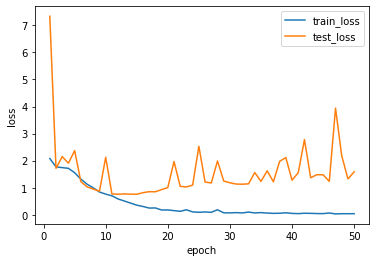

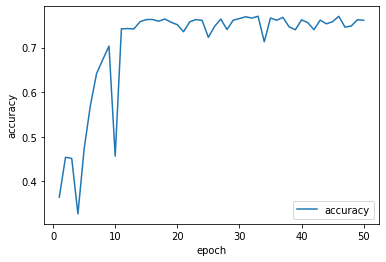

In [ ]:
# Colaboratoryでグラフを表示するには以下が必要（他では必要ない）
%matplotlib inline

# グラフ用のスペースを準備
plt.figure()

# 結果のプロット
plt.plot(range(1, epoch + 1), history['train_loss'], label='train_loss')
plt.plot(range(1, epoch + 1), history['test_loss'], label = 'test_loss')

# x軸y軸に名前を設定
plt.xlabel('epoch')
plt.ylabel('loss')

# 表示
plt.legend()

# 分類精度
plt.figure()
plt.plot(range(1, epoch + 1), history['test_accuracy'], label = 'accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()